# Applying the [JAX](https://github.com/google/jax) framework to a model with realistic noise and wavelength sampling.
Brett Morris & Jens Hoeijmakers


This is a fork of Brett's retrieval demo, applied to high resolution transmission spectra, providing a proof of concept.

In [62]:
%matplotlib inline
# We need to import numpyro first, though we use it last
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro import distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from jax import numpy as jnp
from jax import jit
from jax.scipy.optimize import minimize
from jax.random import PRNGKey, split

import tayph.util as ut
import tayph.system_parameters as sp
import tayph.functions as fun
import tayph.util as ut
from tayph.vartests import typetest,notnegativetest,nantest,postest,typetest_array,dimtest
from tayph.vartests import lentest
import tayph.operations as ops
import tayph.masking as masking
import copy

from pathlib import Path

import arviz
from corner import corner

import astropy.io.fits as fits
import astropy.constants as const
import astropy.units as u


cpu_cores = 4
numpyro.set_host_device_count(cpu_cores)



### Loading opacities.
Opacity functions of various species are located in the `opacity/` folder. We load them using a binary IO script packaged in `tayph`. We save each species in a species object, and keep track of those with a dictionary.

In [63]:
class species:#Species
  def __init__(self, label, tag):
    self.label = label
    self.tag = tag
    

labels = ['Ca', 'Ti', 'V', 'Cr', 'Fe']
tags = [2000,2200,2300,2400,2600]

labels=['Fe']
tags=[2600]
S = {}#This will hold all my species objects.
for i in range(len(labels)):
    S[labels[i]] = species(labels[i],tags[i])

In [64]:
for i in list(S.keys()):
    S[i].path = ut.check_path(f'opacity/VALD_{S[i].tag}e2/Out_00000_60000_02500_n800.bin',exists=True)
    S[i].kappa = jnp.array(ut.read_binary_kitzmann(S[i].path,double=False))
    
k_wn = jnp.arange(len(S['Fe'].kappa))*1e-2#Wavenumbers
k_wl = 1e7/k_wn#Wavelength in nm; common to all the opacity functions.

To make a good choice about what to interpolate this onto, we first load in the data. This is copied out of tayph.

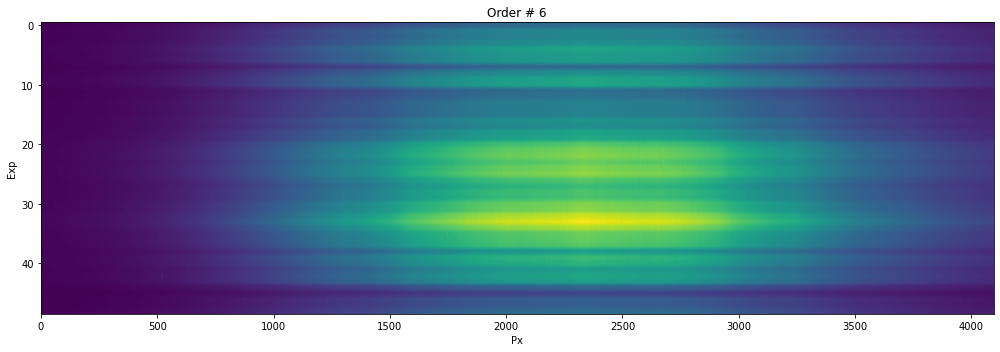

In [92]:
dp = ut.check_path('data/KELT-9/night1/',exists=True)#This follows the file structure of tayph.

air = sp.paramget('air',dp)
do_berv_correction = True
do_keplerian_correction = True

list_of_wls=[]#This will store all the data.
list_of_orders=[]#All of it needs to be loaded into your memory, more than once.
list_of_sigmas=[]#Hope that's ok...
n_negative_total = 0#This will hold the total number of pixels that were set to NaN because

filelist_orders= [str(i) for i in Path(dp).glob('order_*.fits')]
if len(filelist_orders) == 0:#If no order FITS files are found:
    raise Exception(f'Runtime error: No orders_*.fits files were found in {dp}.')
try:
    order_numbers = [int(i.split('order_')[1].split('.')[0]) for i in filelist_orders]
except:
    raise Exception('Runtime error: Failed at casting fits filename numerals to ints. Are the '
    'filenames of all of the spectral orders correctly formatted (e.g. order_5.fits)?')
order_numbers.sort()#This is the ordered list of numerical order IDs.
n_orders = len(order_numbers)


for i in order_numbers:
    wavepath = dp/f'wave_{i}.fits'
    orderpath= dp/f'order_{i}.fits'
    ut.check_path(wavepath,exists=True)
    ut.check_path(orderpath,exists=True)
    wave_order = ut.readfits(wavepath)#2D or 1D?
    order_i = ut.readfits(orderpath)

    #Check dimensionality of wave axis and order. Either 2D or 1D.
    if wave_order.ndim == 2:

        n_px = np.shape(wave_order)[1]#Pixel width of the spectral order.
        dimtest(wave_order,np.shape(order_i),'wave_order in tayph.run_instance()')
    elif wave_order.ndim == 1:
        n_px = len(wave_order)
        dimtest(order_i,[0,n_px],f'order {i} in run_instance()')
    else:
        raise Exception(f'Wavelength axis of order {i} is neither 1D nor 2D.')

    if i == np.min(order_numbers):
        n_exp = np.shape(order_i)[0]#For the first order, we fix n_exp.
    else:
        dimtest(order_i,[n_exp,n_px],f'order {i} in run_instance()')

    #Deal with air or vaccuum wavelengths:
    if air == False:
        list_of_wls.append(copy.deepcopy(wave_order))
    else:
        list_of_wls.append(ops.airtovac(wave_order))


    #Now test for negatives, set them to NaN and track them.
    n_negative = len(order_i[order_i <= 0])
    n_negative_total+=n_negative
    order_i[order_i <= 0] = np.nan #This is very important for later when we are computing
    #average spectra and the like, to avoid divide-by-zero cases.
    postest(order_i,f'order {i} in run_instance().')#make sure whatever comes out here is
    #strictly positive.
    list_of_orders.append(order_i)
    list_of_sigmas.append(np.sqrt(order_i))

    
oi = 6 #This is the order that's going to be plotted below.
plt.figure(figsize=(14,5))
plt.imshow(list_of_orders[oi],aspect='auto')
plt.title(f'Order # {oi}')
plt.xlabel('Px')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()

We now need to do velocity corrections on this data to move to the stellar rest-frame.

In [93]:
rv_cor = 0#This initialises as an int. If any of the following is true, it becomes a float.
if do_berv_correction:
    rv_cor += sp.berv(dp)
if do_keplerian_correction:
    rv_cor-=sp.RV_star(dp)*(1.0)

gamma = 1.0+(rv_cor*u.km/u.s/const.c)#Doppler factor.


list_of_orders_cor = []
list_of_sigmas_cor = []
list_of_wls_cor = []

for i in range(len(list_of_wls)):
    order = list_of_orders[i]
    sigma = list_of_sigmas[i]
    order_cor = order*0.0
    sigma_cor = sigma*0.0
    if list_of_wls[i].ndim==2:
        wl_cor = list_of_wls[i][0]#Interpolate onto the 1st wavelength axis of the series if 2D.
    elif list_of_wls[i].ndim==1:
        wl_cor = list_of_wls[i]
    else:
        raise Exception(f'Wavelength axis of order {i} is neither 1D nor 2D.')

    for j in range(len(list_of_orders[0])):
        if list_of_wls[i].ndim==2:
            if type(rv_cor) != int:#If wl 2D and rv_cor is non-zero:
                order_cor[j] = interp.interp1d(list_of_wls[i][j]*gamma[j],order[j],bounds_error=False)(wl_cor)
                sigma_cor[j] = interp.interp1d(list_of_wls[i][j]*gamma[j],sigma[j],bounds_error=False)(wl_cor)#I checked that this works because it doesn't affect
                #the SNR, apart from wavelength-shifting it.
            else:#If wl is 2D and rv_cor is not populated, there is no multiplication with gamma
                order_cor[j] = interp.interp1d(list_of_wls[i][j],order[j],bounds_error=False)(wl_cor)
                sigma_cor[j] = interp.interp1d(list_of_wls[i][j],sigma[j],bounds_error=False)(wl_cor)
        else:
            if type(rv_cor) != int:#If wl 1D and rv_cor is non-zero:
                order_cor[j] = interp.interp1d(list_of_wls[i]*gamma[j],order[j],bounds_error=False)(wl_cor)
                sigma_cor[j] = interp.interp1d(list_of_wls[i]*gamma[j],sigma[j],bounds_error=False)(wl_cor)
            else:
                #No interpolation at all:
                order_cor[j]=order[j]
                sigma_cor[j]=sigma[j]

    list_of_orders_cor.append(order_cor)
    list_of_sigmas_cor.append(sigma_cor)
    list_of_wls_cor.append(wl_cor)

Now we need to crop out all the in-transit data from these orders, so that we can deal with uncontaminated, out of transit spectra only. I also need to invent a phase axis. And I crop away redder orders to avoid tellurics.

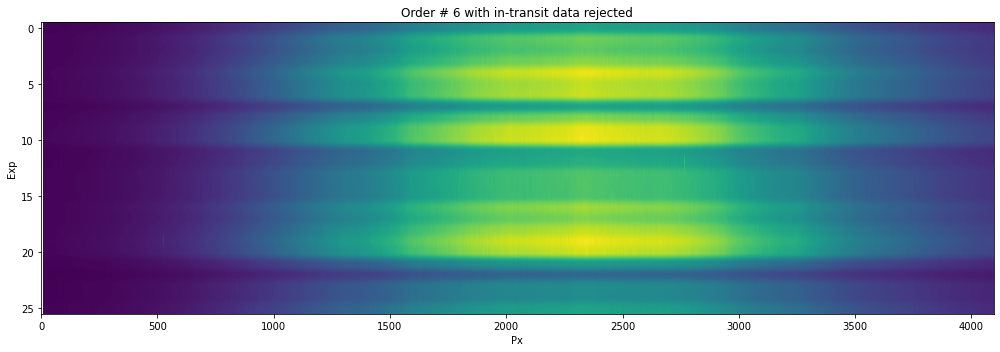

387.5177497257599 415.68117657048697


In [125]:
order_start = 0
order_end = 10

min_wl = np.inf
max_wl = 0


mask = sp.transit(dp)
mask[mask<1]=0

list_of_orders_oot = []
list_of_wls_oot = []
list_of_sigmas_oot = []
for i in range(order_start,np.min([order_end,len(list_of_orders)])):
    list_of_orders_oot.append(list_of_orders_cor[i][mask==1])
    list_of_wls_oot.append(list_of_wls_cor[i])
    list_of_sigmas_oot.append(list_of_sigmas_cor[i][mask==1])
    min_wl = np.min([np.min(list_of_wls_cor[i]),min_wl])
    max_wl = np.max([np.max(list_of_wls_cor[i]),max_wl])
        
list_of_wld = copy.deepcopy(list_of_wls)
        
plt.figure(figsize=(14,5))
plt.imshow(list_of_orders_oot[oi],aspect='auto')
plt.title(f'Order # {oi} with in-transit data rejected')
plt.xlabel('Px')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()

n_exp = len(list_of_orders_oot[0])
phase = np.linspace(-0.05,0.05,n_exp)

print(min_wl,max_wl)

We will now make an intermediate wavelength array on which the opacity functions will live. This is both to throw away unnecessary opacity values to make things more nimble, and to define opacity on a constant-dv grid, which will aide in convolution.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


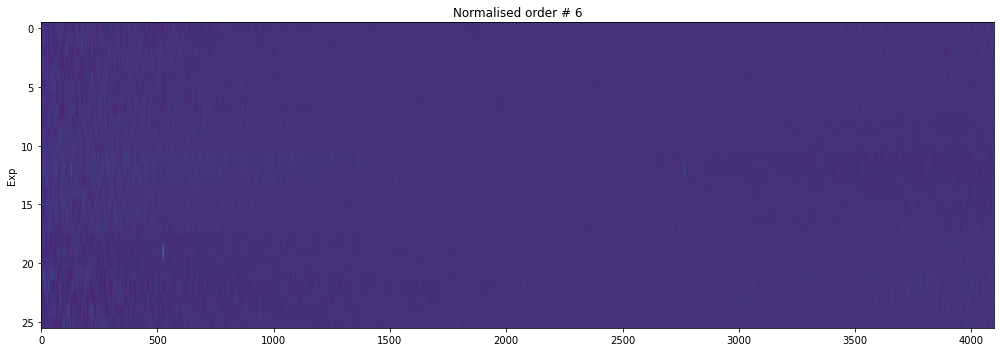

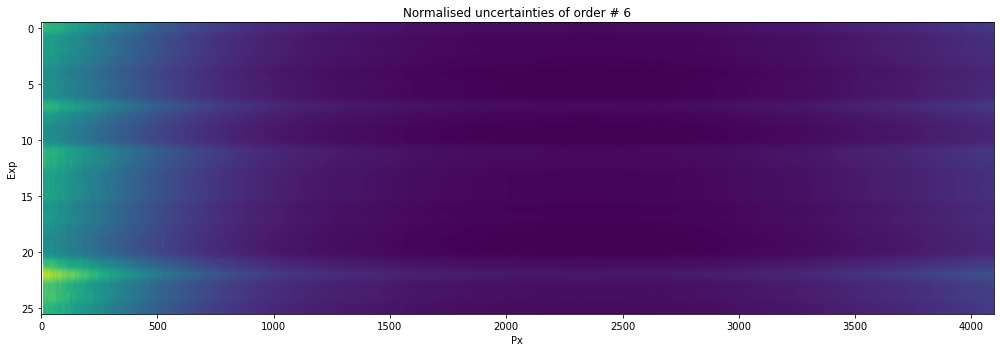

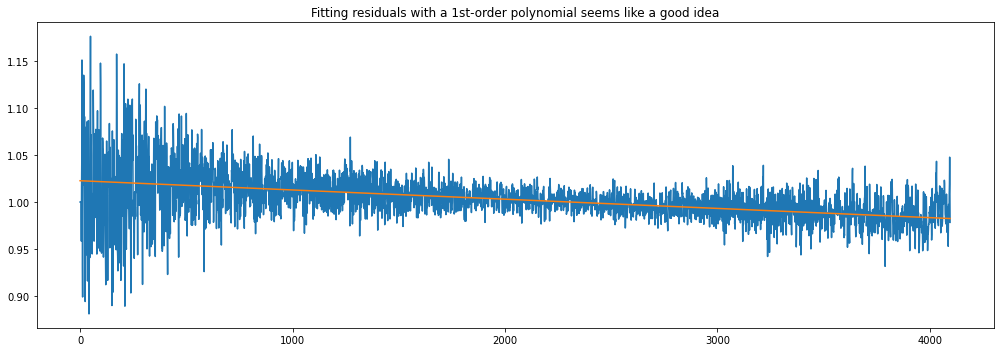

In [126]:

meanfluxes = []#These are the time-dependent average fluxes that we divide out of each order.
meanspecs = []#These are the average spectra that we divide out of each order.
list_of_res = []
list_of_res_e = []

for i in range(len(list_of_orders_oot)):
    order = list_of_orders_oot[i]
    sigma = list_of_sigmas_oot[i]
    meanflux = np.nanmean(order,axis=1)
    meanfluxes.append(meanflux)
    order_norm = (order.T/meanflux).T
    sigma_norm = (sigma.T/meanflux).T
    meanspec = np.nanmean(order_norm,axis=0)
    meanspecs.append(meanspec)
    
    order_clean = order_norm/meanspec
    sigma_clean = sigma_norm/meanspec
    
    #I'm also going to set NaNs to 1.0 and then set sigma to infinite there.
    sigma_clean[np.isfinite(order_clean)==False]=np.inf
    order_clean[np.isfinite(order_clean)==False]=1.0
    
    list_of_res.append(order_clean)
    list_of_res_e.append(sigma_clean)
    
    

    
plt.figure(figsize=(14,5))
plt.imshow(list_of_res[oi],aspect='auto')
plt.title(f'Normalised order # {oi}')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()
    
plt.figure(figsize=(14,5))
plt.imshow(list_of_res_e[oi],aspect='auto')
plt.title(f'Normalised uncertainties of order # {oi}')
plt.xlabel('Px')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()


expfit = 11
xfit = np.arange(len(list_of_res[oi][expfit]))
fit = np.polyfit(xfit, list_of_res[oi][expfit], 1,w = 1/list_of_res_e[oi][expfit])
plt.figure(figsize=(14,5))
plt.plot(xfit,list_of_res[oi][expfit])
plt.plot(xfit,np.poly1d(fit)(xfit))   
plt.title('Fitting residuals with a 1st-order polynomial seems like a good idea')
plt.tight_layout()
plt.show()

So this data is skewed. In the ideal world, a sloped continuum should be part of the model that I am going to fit. But this will generate 2 new free parameters for each exposure in each order. For 70 orders and 30 exposures, this would be over 4000 new free parameters. I do expect that this could would lead to a system of equations that can be solved in the mcmc because all these free parameters are completely decoupled, but I'm not going to tackle that problem for the moment. Instead, we fit these separately and save the filter, supply that to the model and filter the model in the same way. This is equivalent to the strategy of Gibson et al. 2022.

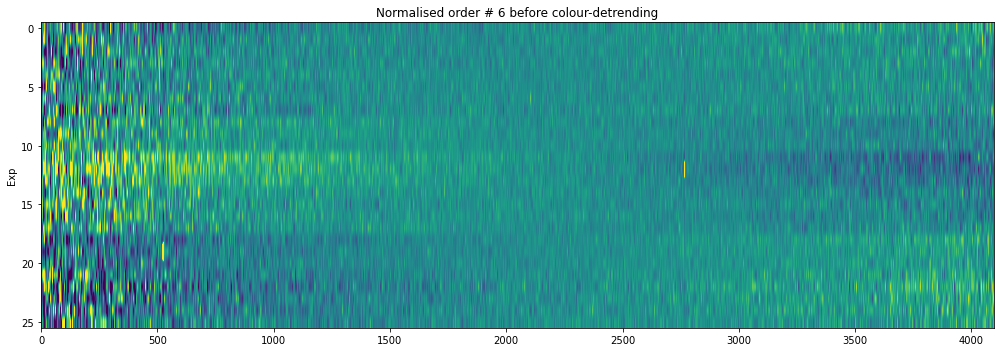

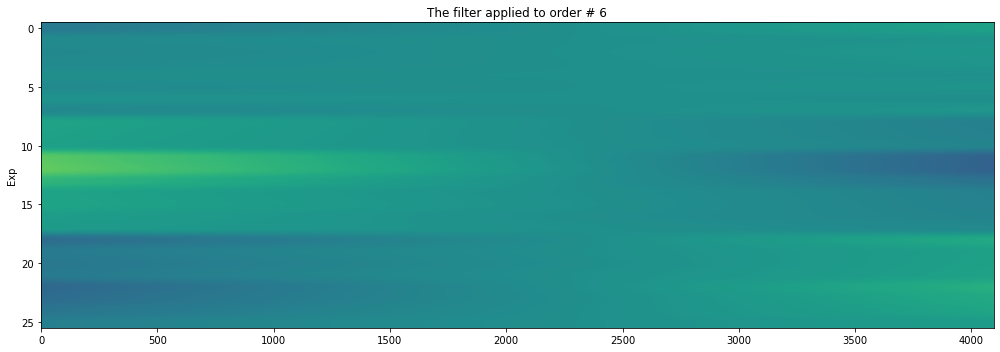

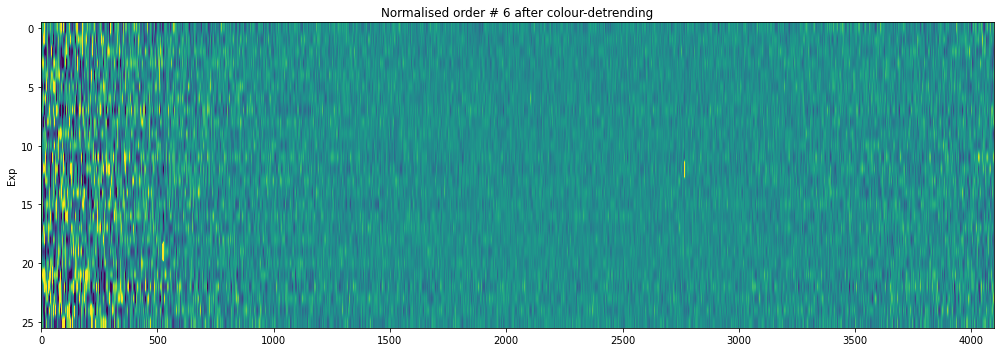

In [127]:
list_of_filters = []
list_of_res_clean = []
list_of_res_clean_e = []
deg = 1
for i in range(len(list_of_res)):
    order = list_of_res[i]
    xfit = np.arange(len(order[0]))
    polyfilter = order*0.0
    fit2d = np.polyfit(xfit,order.T,deg).T

    for j in range(len(order)):
        polyfilter[j] = np.poly1d(fit2d[j])(xfit)
    list_of_filters.append(polyfilter) 
    list_of_res_clean.append(list_of_res[i]/polyfilter)
    list_of_res_clean_e.append(list_of_res_e[i]/polyfilter)
        
stdev = np.nanmedian(list_of_res_e[oi])
plt.figure(figsize=(14,5))
plt.imshow(list_of_res[oi],aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
plt.title(f'Normalised order # {oi} before colour-detrending')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
plt.imshow(list_of_filters[oi],aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
plt.title(f'The filter applied to order # {oi}')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
plt.imshow(list_of_res[oi]/list_of_filters[oi],aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
plt.title(f'Normalised order # {oi} after colour-detrending')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()




This constitutes the data. Buried in this noise is the transmission spectrum, in units of transit radius. We will now need to make a model that can be fit on this 2D data, and this filter needs to be applied to the model just the same. Because the data is now de-trended and the mean is 1.0 per definition, I will now h-stack the data, the uncertainties and the filters. This will make handling the whole thing a lot easier.

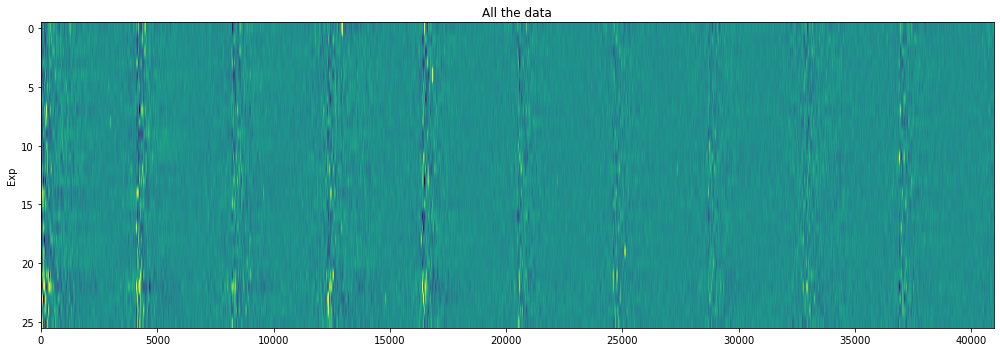

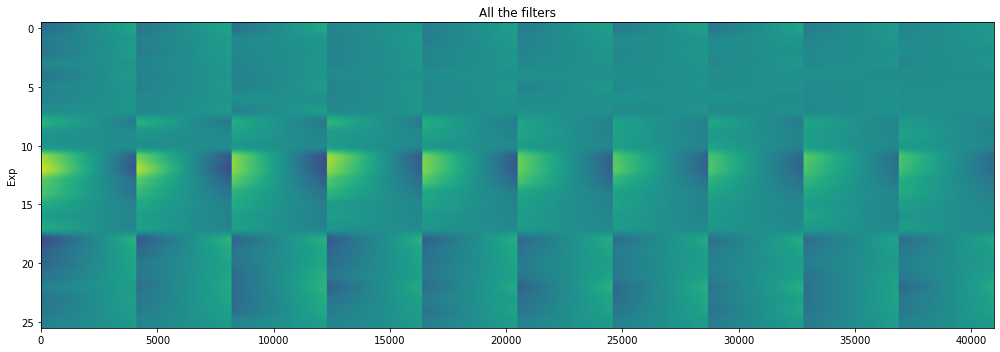

In [130]:
fxd = np.hstack(list_of_res_clean) #This is the data.
err = np.hstack(list_of_res_clean_e)#This is the uncertainty
fxf = np.hstack(list_of_filters)#This is the filter
wld = np.hstack(list_of_wld)#This is the wavelength axis.

plt.figure(figsize=(14,5))
plt.imshow(fxd,aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
plt.title(f'All the data')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
plt.imshow(fxf,aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
plt.title(f'All the filters')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()

Interestingly, the filters all have the same shape. Maybe I can leverage this during the retrieval?

Now on to making the model. The first thing that we're going to do is to prepare the opacities, to convert them to a new wavelength grid that will allow us to blur the resulting transmission spectrum.

In [96]:
#We are going to bracket the minimum and maximum wavelengths of the intermediate wavelength array by 500 km/s in velocity.
doppler_factor = (500*u.km/u.s / const.c).decompose().value
min_wl*=(1-doppler_factor)
max_wl*=(1+doppler_factor)


for i in list(S.keys()):
    wli,S[i].kappa_i,dv = ops.constant_velocity_wl_grid(np.array(k_wl[1:]),np.array(S[i].kappa[1:]),
                                                       oversampling=1.0,minmax=[min_wl,max_wl]) # The intermediate wavelength grid.
                                                        #Index it from 1 onwards because the first value is np.inf.

So now we have opacity functions interpolated onto a fine-grained constant-dv grid.
The next task is to make a model that matches the order-wise data. This is tricky because each order has its own continuum normalization, so the number of free parameters may be mad.

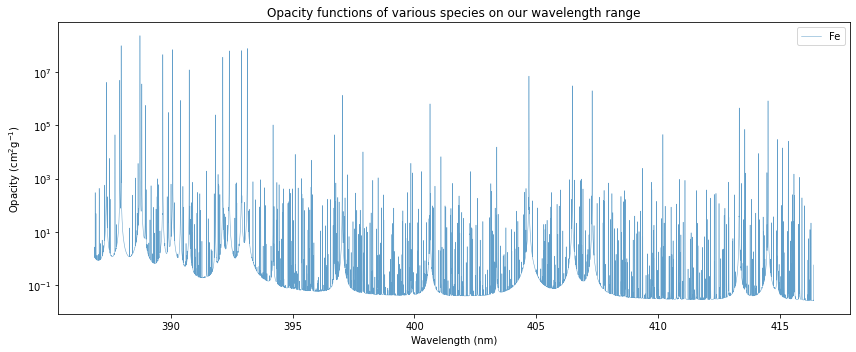

In [97]:

plt.figure(figsize=(12,5))

for i in list(S.keys()):
    plt.plot(wli,S[i].kappa_i,label=i,linewidth=0.5,alpha=0.7)
plt.yscale('log')
plt.xlabel('Wavelength (nm)')
plt.title("Opacity functions of various species on our wavelength range")
plt.ylabel('Opacity (cm$^2$g$^{-1}$)')
plt.legend()
plt.tight_layout()
plt.show()

### Defining the planet

In [78]:
gamma = 0.57721
RJ = const.R_jup.cgs.value
MJ = const.M_jup.cgs.value
G = const.G.cgs.value
Rsun = const.R_sun.cgs.value

P0 = (1.0*u.bar).cgs.value#bar
R0 = 1.8*RJ
M0 = 1.2*MJ
k = const.k_B.cgs.value
m = 2.33*const.u.cgs.value
Rs = 1.4*Rsun
g = G*M0 / R0**2

### The order-by-order model

Let's specify the model that we will fit to the data using the numpy module within jax. We'll also "decorate" it with the `jit` decorator, which will compile the function for us at runtime. 

This model is complicated for 4 reasons.<br>
First of all, because there is a variety of species. Each of these has their own opacity function and abundance. I set it up such that the first species provided is Fe, and all the other species are then measured relative to Fe.<br>
Secondly, the model needs to be broadened and shifted. This adds more free parameters, and a convolution operation.

In [ ]:
# @jit
def model_jax_adv(p,wl,list_of_kappas,order=1):
    n_species = len(list_of_kappas)#The first species should be Fe.
    T = p[0]
    logchi_fe = p[1]
    logratios = p[1:n_species]
    logk0 = p[n_species]
    coefs = p[n_species:] #polynomial coefficients for order 1
    print(T)
    print(logchi_fe)
    print(logratios)
    print(logk0)
    print(coefs)
#     T,logchi_fe,logratio_cafe,logratio_tife,logratio_vfe,logratio_crfe,logk0,c = p 
#     H = k*T/m/g
#     K = 10**logchi_fe*(x1+10**logratio_cafe*x2+10**logratio_tife*x3+10**logratio_vfe*x4+10**logratio_crfe*x5)+10**logk0#The total opacity is the vmr of Fe plus the constant gray haze.
#     R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
#     return (c-R**2 / Rs**2)

# @jit
# def chi2_jax_adv(p, x1, x2, x3, x4, x5, y, yerr):
#     """chi^2 function written for minimization with jax"""
#     return jnp.sum((model_jax_adv(p, x1,x2,x3,x4,x5) - y)**2 / yerr**2)

p = [2500.0,[S['Fe'].kappa_i],]

In [ ]:
np.random.seed(42)

true_p = [2550.0,-5.1,0.3,-1.1,-2.0,-1.8,-2.1,1.0]#T, log(chi_fe), log(chi_ca/chi_fe), log(chi_ti/chi_fe), log(chi_v/chi_fe), log(chi_cr/chi_fe), k0, c. 

SNR = 200.0
x = wl
y1 = model_jax_adv(true_p,k_Fe_i,k_Ca_i,k_Ti_i,k_V_i,k_Cr_i)
yerr = 1.0/SNR
y = y1 + np.random.normal(scale=yerr, size=(len(x)))

yrange = np.max([3*yerr,np.abs(np.max(y1)-np.min(y1))])

plt.figure(figsize=(14,5))
plt.plot(x, y,linewidth=0.8)
plt.plot(x,y1,alpha=0.5)
plt.xlim(392.1,392.5)
plt.ylim(np.mean(y)-yrange,np.mean(y)+yrange)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative in-transit flux')
plt.tight_layout()
plt.show()

In [ ]:
def numpyro_model_adv():
    """
    Define a model to sample with the No U-Turn Sampler (NUTS) via numpyro.
    
    The two Gaussians are defined by an amplitude, mean, and standard deviation.
    
    To find unique solutions for the two Gaussians, we put non-overlapping bounded 
    priors on the two amplitudes, but vary the means and stddev's with identical 
    uniform priors. 
    """
    # Define a prior for the temperature:
    T_prior = numpyro.sample('T', dist.Uniform(low=1000, high=6000))
    
    # Uniform prior for log(chi_fe)
    chi_fe_prior = numpyro.sample(
        'log($\chi_{Fe}$)', dist.Uniform(low=-10, high=-3))
 
    # Uniform prior for log(chi_ca/chi_fe)
    chi_ca_prior = numpyro.sample(
        'log($\chi_{Ca}$ / $\chi_{Fe}$)', dist.Uniform(low=-3, high=1))

    # Uniform prior for log(chi_ti/chi_fe)
    chi_ti_prior = numpyro.sample(
        'log($\chi_{Ti}$ / $\chi_{Fe}$)', dist.Uniform(low=-4, high=0.5))

    # Uniform prior for log(chi_v/chi_fe)
    chi_v_prior = numpyro.sample(
        'log($\chi_{V}$ / $\chi_{Fe}$)', dist.Uniform(low=-5, high=-0.5))
    
    # Uniform prior for log(chi_cr/chi_fe)
    chi_cr_prior = numpyro.sample(
        'log($\chi_{Cr}$ / $\chi_{Fe}$)', dist.Uniform(low=-4, high=0.5))
    
    # Uniform prior for log(k0):
    k0_prior = numpyro.sample('log($\kappa_0$)', dist.Uniform(low=-5, high=0))

#     Uniform prior for log(k0):
#     c_prior = numpyro.sample('c', dist.Normal(loc=1.0, scale=0.001))
    c_prior = numpyro.sample('c', dist.Uniform(low=0.999, high=1.001))
    
    # Normally distributed likelihood
    numpyro.sample("obs", dist.Normal(loc=model_jax_adv([T_prior, chi_fe_prior, chi_ca_prior,
                                                         chi_ti_prior,  chi_v_prior,  
                                                         chi_cr_prior, k0_prior,c_prior], 
                                                        k_Fe_i,k_Ca_i,k_Ti_i,k_V_i,k_Cr_i),scale=yerr), obs=y)

In [ ]:
from jax.random import PRNGKey, split
import arviz
from corner import corner
rng_seed = 42
rng_keys = split(PRNGKey(rng_seed),cpu_cores
)

# Define a sampler, using here the No U-Turn Sampler (NUTS)
# with a dense mass matrix:
sampler = NUTS(
    numpyro_model_adv, 
    dense_mass=True
)

# Monte Carlo sampling for a number of steps and parallel chains: 
mcmc = MCMC(
    sampler, 
    num_warmup=500, 
    num_samples=3000, 
    num_chains=4
)

# Run the MCMC
mcmc.run(rng_keys)

# arviz converts a numpyro MCMC object to an `InferenceData` object based on xarray:
result = arviz.from_numpyro(mcmc)

# these are the inputs to the synthetic double-gaussian profile (blue lines)
truths = {'T': true_p[0], 
          'log($\chi_{Fe}$)': true_p[1], 
          'log($\chi_{Ca}$ / $\chi_{Fe}$)' : true_p[2],
          'log($\chi_{Ti}$ / $\chi_{Fe}$)' : true_p[2],
          'log($\chi_{V}$ / $\chi_{Fe}$)' : true_p[3],
          'log($\chi_{Cr}$ / $\chi_{Fe}$)' : true_p[4],
          'log($\kappa_0$)': true_p[5], 
          'c': true_p[6]}
# make a corner plot
corner(
    result, 
    quiet=True, 
    truths=truths
);

In [ ]:
result = arviz.from_numpyro(mcmc)

# these are the inputs to the synthetic double-gaussian profile (blue lines)
truths = {'T': true_p[0], 
          'log($\chi_{Fe}$)': true_p[1], 
          'log($\chi_{Ca}$ / $\chi_{Fe}$)' : true_p[2],
          'log($\chi_{Ti}$ / $\chi_{Fe}$)' : true_p[3],
          'log($\chi_{V}$ / $\chi_{Fe}$)' : true_p[4],
          'log($\chi_{Cr}$ / $\chi_{Fe}$)' : true_p[5],
          'log($\kappa_0$)': true_p[6], 
          'c': true_p[7]}
# make a corner plot
corner(
    result, 
    quiet=True, 
    truths=truths
);

This is glorious! With an SNR = 200 spectrum (in the blue), you can retrieve abundance ratios in this inflated 2,500 K ultra-hot Jupiter, with an uncertainty of about 0.5 dex, despite the massive pressure-abundance degeneracy.
Of course, there are many questions: What if the data does not have a flat continuum (although it looks flat). What if the data includes species that are not in the model; especially complex species like TiO? Can we apply H&K 2017 in the first place? 
<br><br>
To make progress, the first step is to apply this methodology to a form of real data, with a simulated planet injected into it. This is the topic of the next notebook.